In [809]:
import numpy as np
import pandas as pd
from pprint import pprint
import json
from typing import Dict, Optional, Text, Tuple, Union
from PIL import Image
from collections import defaultdict

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
from itertools import chain
from sklearn.preprocessing import OneHotEncoder

In [786]:
def make_df_from_fixture(fixture_dict:dict):
    """convert a django format fixture into a pandas df """
    
    index = []
    fields = []
    for m in metadata:
        index.append(m["pk"])
        fields.append(m["fields"])

    col_names = m["fields"].keys()
    col_names = list(col_names)
    
    return pd.DataFrame(index=index, data=fields, columns=col_names)

In [773]:
def _take_along_axis(arr: tf.Tensor, indices: tf.Tensor) -> tf.Tensor:
    """Partial TF implementation of numpy.take_along_axis.
    See
    https://numpy.org/doc/stable/reference/generated/numpy.take_along_axis.html
    for details.
    Args:
    arr: 2D matrix of source values.
    indices: 2D matrix of indices.
    Returns:
    2D matrix of values selected from the input.
    """

    row_indices = tf.tile(
      tf.expand_dims(tf.range(tf.shape(indices)[0]), 1),
      [1, tf.shape(indices)[1]])
    gather_indices = tf.concat(
      [tf.reshape(row_indices, (-1, 1)),
       tf.reshape(indices, (-1, 1))], axis=1)

    return tf.reshape(tf.gather_nd(arr, gather_indices), tf.shape(indices))


# modified from tensorflow source code to prevent type error
def _exclude(scores: tf.Tensor, identifiers: tf.Tensor, exclude: tf.Tensor,
             k: int) -> Tuple[tf.Tensor, tf.Tensor]:
    """Removes a subset of candidates from top K candidates.
    For each row of inputs excludes those candidates whose identifiers match
    any of the identifiers present in the exclude matrix for that row.
    Args:
    scores: 2D matrix of candidate scores.
    identifiers: 2D matrix of candidate identifiers.
    exclude: 2D matrix of identifiers to exclude.
    k: Number of candidates to return.
    Returns:
    Tuple of (scores, indices) of candidates after exclusions.
    """

    idents = tf.expand_dims(identifiers, -1)
    exclude = tf.expand_dims(exclude, 1)

    isin = tf.math.reduce_any(tf.math.equal(idents, exclude), -1)

    # Set the scores of the excluded candidates to a very low value.
#     adjusted_scores = (scores - tf.cast(isin, tf.float32) * 1.0e5)
    
    ##### cast input scores to prevent type error
    adjusted_scores = (tf.cast(scores, tf.float64) - tf.cast(isin, tf.float64) * 1.0e5)

    k = tf.math.minimum(k, tf.shape(scores)[1])

    _, indices = tf.math.top_k(adjusted_scores, k=k)

    return _take_along_axis(scores,
                          indices), _take_along_axis(identifiers, indices)


def top_k_with_exclusions(topk, query, exclusions, k=100):
    """
    topk: instance of tensorflow TopK class
    query: vector to find similar records
    exclusions: ids of the records to exclude
    k: number of results to return
    """
    
    adjusted_k = k + exclusions.shape[1]
    x, y = topk.call(queries=query, k=adjusted_k)
    
    return _exclude(x, y, exclude=exclusions, k=k)

In [612]:
def make_class_record_dict(encoded_ser):
    """
    take a pd.Series where the index is the record id (that correlates to the id in the Retrieval model) and the values are the encoded classes as integers
    return a dictionary of sets
    """ 
    key_dict = {}
    for key in np.unique(encoded_ser):
#         print(key)
        fltr = encoded_ser == key
#         print(fltr.sum())
        key_dict[key] = set(encoded_ser[fltr].index)

    return key_dict

In [814]:
def flatten_series_of_lists(ser:pd.Series):
    """
    flatten a series of lists where the relationship between the index and the values 
    needs to be maintained
    ser: pd.Series where the values are lists
    """
    
    indices = []
    keys = []
    for index, row in ser.iteritems():
        if type(row) != list:
            print(row)
        else:
            for key in row:
                indices.append(index)
                keys.append(key)

    return pd.Series(index=indices, data=keys, name=ser.name)

In [848]:
def create_class_dict(ser):
    
    # use a default dict to return -1 in case key is not found
    
    class_dict = defaultdict(lambda: -1)
    classes = np.unique(ser)
    indices = np.arange(len(mat_tecs))
    class_dict.update(dict(zip(classes, indices)))
    
    return classes, indices, class_dict


In [852]:
def series_to_class_record_dict(ser, split_char=None):
    """
    convert a comma separated string series of classes into a dictionary of encoded classes
    ser: pd.Series of strings
    split_char: string or None, character to split strings in the series by. e.g. ','
    returns: tuple of class_dict, class_record_dict
    
    example input:
    ser
    
    1000        Kaltnadel, Radierung
    1001    Japanpapier, Holzschnitt
    1002      Radierung, Kupferstich
    
    split_char
    ","
    
    example return
    (
     {'holzschnitt': 0,
      'japanpapier': 1,
      'kaltnadel': 2,
      'kupferstich': 3,
      'radierung': 4},
      
     {0: {1001}, 
      1: {1001}, 
      2: {1000}, 
      3: {1002},
      4: {1000, 1002}})
    
    """

    ser = ser.str.lower()
    # split into series of lists strings based split_char
    if split_char:
        ser = ser.str.split(split_char)
        # flatten series of lists
        ser = flatten_series_of_lists(ser)
    
    # strip whitespace from strings
    if ser.dtype == "O":
        ser = ser.str.strip()

    # create vocabulary dictionary
    classes, indices, class_dict = create_class_dict(ser)

    # encode the series
    ser_enco = ser.map(class_dict)
    
    # create set dictionary with the records per class
    class_record_dict = make_class_record_dict(ser_enco)
    
    return class_dict, class_record_dict
    

In [1015]:
def find_records_to_exclude_by_class(classes_to_keep:list, class_records_dict:dict, record_ids_set:set):
    """
    using sets get the records to exclude and include by filtering the relevant classes
    
    classes_to_keep:list of ints, the ids of the classes to included in the results
    class_records_dict: dict of format {class_id:set_of_record ids}
    record_ids_set: all of the potential records
    
    returns
    (records_to_exclude, records_to_include)
    """
    
    classes_to_keep = set(classes_to_keep)
    # make a set of the record ids to keep
    records_to_include = set()
    for class_id in classes_to_keep:
        records_to_include.update(class_records_dict[class_id])

    # remove the records that belong to the target classes that we want to keep
    # make a set of the record ids to remove
    records_to_exclude = record_ids_set.difference(records_to_include)

    return records_to_exclude, records_to_include

```python

%%timeit
keys_to_exclude = keys_to_keep.difference(set(mat_tecs_indices))
```
<hr>
4.68 µs ± 412 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


```python
%%timeit
keys_to_exclude= [k for k in mat_tecs_indices if k not in keys_to_keep]
```
<hr>
9.26 µs ± 1.24 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)

```python
%%timeit
records_to_exclude = []
for k in keys_to_exclude:
    records_to_exclude.extend(mat_tec_dict[k])
records_to_exclude = set(records_to_exclude)
```
<hr>
> 10.3 µs ± 1.22 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)

```python
%%timeit
records_to_exclude = set()
for k in keys_to_exclude:
    records_to_exclude.update(mat_tec_dict[k])
```
<hr>
> 7.01 µs ± 1.41 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)

In [202]:
# Ratings data.
ratings = tfds.load('movielens/100k-ratings', split="train")
# Features of all the available movies.
movies = tfds.load('movielens/100k-movies', split="train")

In [210]:
for x in ratings.take(2).as_numpy_iterator():
    pprint(x)
print(type(x))

{'bucketized_user_age': 45.0,
 'movie_genres': array([7]),
 'movie_id': b'357',
 'movie_title': b"One Flew Over the Cuckoo's Nest (1975)",
 'raw_user_age': 46.0,
 'timestamp': 879024327,
 'user_gender': True,
 'user_id': b'138',
 'user_occupation_label': 4,
 'user_occupation_text': b'doctor',
 'user_rating': 4.0,
 'user_zip_code': b'53211'}
{'bucketized_user_age': 25.0,
 'movie_genres': array([ 4, 14]),
 'movie_id': b'709',
 'movie_title': b'Strictly Ballroom (1992)',
 'raw_user_age': 32.0,
 'timestamp': 875654590,
 'user_gender': True,
 'user_id': b'92',
 'user_occupation_label': 5,
 'user_occupation_text': b'entertainment',
 'user_rating': 2.0,
 'user_zip_code': b'80525'}
<class 'dict'>


In [685]:
# Select the basic features.
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"]
})
movies = movies.map(lambda x: x["movie_title"])

In [686]:
data = {"drawing":[1,0,0,0,0],"print":[0,1,1,1,0],"sculpture":[0,0,0,0,1],}
df = pd.DataFrame(data)
df.index = df.index.rename("id")
features = df.values
df

,drawing,print,sculpture
id,,,
0,1,0,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,0,1


In [687]:
embeddings = np.random.rand(5,10)
np.arange(0,10).tolist()
df.loc[:,np.arange(0,10).tolist()] = embeddings

In [688]:
df

,drawing,print,sculpture,0,1,2,3,4,5,6,7,8,9
id,,,,,,,,,,,,,
0,1,0,0,0.767248,0.620516,0.410775,0.461558,0.718805,0.177111,0.471767,0.759910,0.557864,0.964550
1,0,1,0,0.809702,0.419399,0.227564,0.417899,0.190622,0.578240,0.101279,0.099110,0.503395,0.104461
2,0,1,0,0.973681,0.335535,0.350783,0.698543,0.334066,0.374646,0.749737,0.974261,0.195164,0.475829
3,0,1,0,0.496965,0.985987,0.032830,0.237589,0.304416,0.935405,0.795392,0.156405,0.342655,0.404022
4,0,0,1,0.831910,0.346385,0.054208,0.583639,0.500016,0.081777,0.321796,0.446654,0.745765,0.721978


In [689]:
df.values

array([[1.        , 0.        , 0.        , 0.76724763, 0.62051575,
        0.41077525, 0.4615578 , 0.71880495, 0.17711136, 0.47176701,
        0.75990981, 0.5578637 , 0.96454972],
       [0.        , 1.        , 0.        , 0.80970205, 0.41939873,
        0.22756364, 0.41789943, 0.19062233, 0.57823994, 0.10127867,
        0.09910989, 0.50339519, 0.10446056],
       [0.        , 1.        , 0.        , 0.97368052, 0.33553468,
        0.35078347, 0.69854322, 0.33406609, 0.37464643, 0.74973673,
        0.97426135, 0.19516389, 0.47582864],
       [0.        , 1.        , 0.        , 0.49696488, 0.98598668,
        0.03282993, 0.23758861, 0.30441637, 0.93540523, 0.79539221,
        0.15640468, 0.34265506, 0.40402212],
       [0.        , 0.        , 1.        , 0.83190967, 0.34638534,
        0.05420779, 0.58363924, 0.50001552, 0.08177656, 0.32179578,
        0.44665446, 0.74576465, 0.72197779]])

In [690]:
# init the topk
topk = tfrs.layers.factorized_top_k.BruteForce(k=2)

In [691]:
# %%timeit
# create the index for the topk NN model
topk = topk.index(df.values)

In [692]:
# create a query
is_drawing = 0
is_print = 1
is_sculpture = 0
handmade_features = [is_drawing, is_print, is_sculpture]
calculated_features = embeddings[1,:] *.7
query_1 = np.hstack((handmade_features, calculated_features)).astype(np.float64)
query_1 = tf.constant(np.array([query_1,]), dtype=np.float64)
k=2
query_1

<tf.Tensor: shape=(1, 13), dtype=float64, numpy=
array([[0.        , 1.        , 0.        , 0.56679143, 0.29357911,
        0.15929455, 0.2925296 , 0.13343563, 0.40476796, 0.07089507,
        0.06937692, 0.35237663, 0.07312239]])>

In [11]:
# get the brute force top k results
topk.call(query_1, k=k)

(<tf.Tensor: shape=(1, 2), dtype=float64, numpy=array([[2.55656005, 2.29081205]])>,
 <tf.Tensor: shape=(1, 2), dtype=int32, numpy=array([[1, 2]], dtype=int32)>)

In [12]:
# create a query with exclusions
exclusions=tf.constant([[1]])
top_k_with_exclusions(topk, query_1, exclusions, k)

(<tf.Tensor: shape=(1, 2), dtype=float64, numpy=array([[2.29081205, 1.90546734]])>,
 <tf.Tensor: shape=(1, 2), dtype=int32, numpy=array([[2, 3]], dtype=int32)>)

# Test with a sample of Graphische Sammlung Data 

## Load extracted feature vectors from file

In [830]:
df_feat = pd.read_csv("../data/processed/ethz/features_vgg16_imagenet.csv", header=None)
# fix file path due to difference in local setups
df_feat[0] = df_feat[0].str.replace("../data/processed/","../data/processed/ethz/") 

In [831]:
df_feat.shape

(20835, 513)

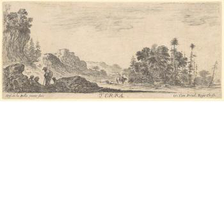

In [832]:
img_fpaths = df_feat.iloc[:,0].values
# check that the file paths are correct
img_fpth = img_fpaths[0]
Image.open(img_fpth)


In [833]:
# create a map from record_indices to model_indices
df_fpath = df_feat.iloc[:,[0]]
df_fpath = df_fpath.rename(columns={0:"fpath"})
df_fpath['record_id'] = df_fpath["fpath"].str.rsplit(pat="/", n=1, expand=True)[1]
df_fpath['record_id'] = df_fpath['record_id'].str.split(pat=".", n=1, expand=True)[0]
map_record_id_model_id = dict(zip(df_fpath['record_id'].astype(int).to_list(), list(df_fpath.index)))



# load exctracted feature vectors
fpath = "../data/processed/default/features.csv"
df_feat = pd.read_csv(fpath, header=None)

df_feat.head()

## Load image metadata

In [880]:
# load metadata
fpath = "../data/processed/ethz/fixtures/ImageMetadata.json"

with open(fpath, "r") as f:
    metadata = json.load(f)
    
df_meta = make_df_from_fixture(metadata)
df_meta.shape

(21464, 12)

In [881]:
df_meta.head()

,record_id,image_url,inventory_number,person,date,title,classification,material_technique,institution_isil,record_url,image_licence,created_date
1000,3,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 014392,Monogrammist IB [Nagler III 1950] (1523 - 1530...,Enstehung des Druckträgers: 1529,Marcus Curtius stürzt sich in die Erdspalte,Druckgraphik,"Papier vergé, Kupferstich",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
1001,11,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,Z 000326,"Ritz, Raphael (1829 - 1894), Künstler",Entstehung: 1850 - 1900 [zweite Hälfte des 19....,Champsec,Handzeichnung,Bleistift,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
1002,18,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 009945,"Franco, Battista (1510 um - 1561)",Enstehung des Druckträgers: Um 1525 - 1561,Philister bringen die Bundeslade in den Tempel...,Druckgraphik,"Kupferstich, dubliert, Radierung",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
1003,19,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 013409,"Sadeler (der Jüngere), Egidius (1570 um - 1629...",Enstehung des Druckträgers: 1607,Grosser Saal im Schloss in Prag [Linke Bildhäl...,Druckgraphik,Kupferstich,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
1004,33,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 011145,"Doo, George Thomas (1800 - 1886), Künstler; Wy...",Enstehung des Druckträgers: 1835,Schöne Försterin,Druckgraphik,"Kupferstich, Radierung",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00


### map model ids to record ids


In [882]:
df_meta.index = df_meta.index.rename("db_id")

df_meta["model_id"] = df_meta["record_id"].map(map_record_id_model_id)

# set as pandas nullable int type
df_meta["model_id"] = df_meta["model_id"].astype("Int64")

# filter out model nans
df_meta = df_meta.loc[df_meta["model_id"].notna(),:]
# set model_id as index
df_meta = df_meta.reset_index().set_index("model_id")

In [924]:
split_char=","
ser = df_meta["material_technique"].dropna()
ser = ser.str.lower()
# split into series of lists strings based split_char
if split_char:
    ser = ser.str.split(split_char)
    # flatten series of lists
    ser = flatten_series_of_lists(ser)

# strip whitespace from strings
if ser.dtype == "O":
    ser = ser.str.strip()
classes, indices, class_dict = create_class_dict(ser)

# encode the series
ser_enco = ser.map(class_dict)
ser_enco

6379    -1
6379    48
6340    48
6340    18
6340    -1
        ..
4001    -1
4001    -1
4001    39
4000    -1
4000    -1
Name: material_technique, Length: 36447, dtype: int64

In [927]:
np.sort(ser_enco.unique())

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [928]:
# create set dictionary with the records per class
class_record_dict = make_class_record_dict(ser_enco)

In [929]:
class_record_dict.keys()

dict_keys([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [936]:
class_record_dict[6]

{172, 173, 194, 195, 197, 200, 201, 3281, 3296, 3376, 3384, 3417, 3520, 10947}

In [930]:
df_meta.head()

,db_id,record_id,image_url,inventory_number,person,date,title,classification,material_technique,institution_isil,record_url,image_licence,created_date
model_id,,,,,,,,,,,,,
6379,1000,3,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 014392,Monogrammist IB [Nagler III 1950] (1523 - 1530...,Enstehung des Druckträgers: 1529,Marcus Curtius stürzt sich in die Erdspalte,Druckgraphik,"Papier vergé, Kupferstich",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
6340,1002,18,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 009945,"Franco, Battista (1510 um - 1561)",Enstehung des Druckträgers: Um 1525 - 1561,Philister bringen die Bundeslade in den Tempel...,Druckgraphik,"Kupferstich, dubliert, Radierung",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
6347,1003,19,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 013409,"Sadeler (der Jüngere), Egidius (1570 um - 1629...",Enstehung des Druckträgers: 1607,Grosser Saal im Schloss in Prag [Linke Bildhäl...,Druckgraphik,Kupferstich,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
6328,1004,33,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 011145,"Doo, George Thomas (1800 - 1886), Künstler; Wy...",Enstehung des Druckträgers: 1835,Schöne Försterin,Druckgraphik,"Kupferstich, Radierung",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
6248,1005,49,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 012158,"Nanteuil, Robert (1623 - 1678); Elle, Louis (1...",Enstehung des Druckträgers: 1660,Porträt von Charles-Paris d'Orléans-Longuevill...,Druckgraphik,Kupferstich,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00


for row in df_meta["person"].head(40):
    
    print(row,'\n')

for row in df_meta["date"].head(40):
    print(row)

for row in df_meta["date"].tail(40):
    print(row)

In [900]:
# process a feature column
ser = df_meta.loc[:,"material_technique"].dropna()
record_ids_set = set(ser.index)
record_ids_set

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [899]:
mat_tec_class_dict, mat_tec_records_dict = series_to_class_record_dict(ser, split_char=",")
mat_tec_records_dict

{-1: {0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,


In [896]:
pprint(mat_tec_class_dict['kupferstich'])

48


In [887]:
# process a feature column
ser = df_meta.loc[:,"classification"].dropna(how='any')
classification_class_dict, classification_records_dict = series_to_class_record_dict(ser, split_char=None)

In [947]:
type(classification_records_dict[0])

set

In [963]:
# filter using that column
classes_to_keep=[2]
records_to_exclude, records_to_include = find_records_to_exclude_by_class(classes_to_keep, classification_records_dict, record_ids_set)

records_to_exclude

In [1061]:
# process a feature column
ser = df_meta.loc[:,"material_technique"].dropna(how='any')
record_ids_set = set(ser.index)
materials_class_dict, materials_records_dict = series_to_class_record_dict(ser, split_char=",")

materials_label_lookup = dict(zip(materials_class_dict.values(),materials_class_dict.keys()))

In [1062]:
len(record_ids_set)

20776

In [1110]:
# radierung should be found!!!!
materials_class_dict["radierung"]

-1

In [1193]:
for k in materials_class_dict.keys():
    print(f"|{k}|")

|abklatsch|
|aluminium|
|aluminiumdruck|
|aquarell|
|aquarelliert|
|aquatinta|
|aufgezogen|
|blattgold|
|bleistift|
|bleiweiss|
|chiaroscuroschnitt|
|chinapapier|
|chine collé|
|cliché verre|
|collage|
|crayonmanier|
|direktätzung|
|druck|
|dubliert|
|duplexdruck|
|eisenradierung|
|farbholzschnitt|
|farblithographie|
|farbradierung|
|farbstift|
|feder|
|federlithographie|
|firnis|
|gehöht|
|gouache|
|graphit|
|grundiert|
|halbkarton|
|handkoloriert|
|heliogravüre|
|hochdruck|
|holzschnitt|
|holzstich|
|holzstock|
|japanpapier|
|kaltnadel|
|karton|
|kohle|
|koloriert|
|kreide|
|kreidelithographie|
|kupfer|
|kupferplatte|
|kupferstich|
|laviert|
|papier vergé|
|radierung|
|velin|
|stahlstich|
|roulette|
|silberstift|
|letterndruck|
|punktiermanier|
|reiberdruck|
|lithographie|
|mezzotinto|
|zinkätzung|
|photopapier|
|schwarzweiss-photographie|
|pinsel|
|rötel|
|weisslinienholzschnitt|
|überarbeitet|
|umrissen|
|niello-manier|
|metallschnitt|
|strichgravur|
|pinsellithographie|
|pergament

In [1194]:
materials_class_dict["kupferplatte"]

47

In [1210]:
# filter using that column
class_id = materials_class_dict["kupferstich"]
# class_id = 41
classes_to_keep= [class_id,] #list(materials_records_dict.keys())[1:] # [class_id,] 
records_to_exclude, records_to_include = find_records_to_exclude_by_class(classes_to_keep, materials_records_dict, record_ids_set)

for class_id in classes_to_keep:
    print(class_id, " : ", materials_label_lookup[class_id])
    
print("records_to_include: ", len(records_to_include))
print("records_to_exclude: ", len(records_to_exclude))

48  :  kupferstich
records_to_include:  9136
records_to_exclude:  11640


In [1211]:
set_length = len(materials_records_dict[class_id])
print(set_length)
incl_len = len(records_to_include)
print(incl_len)
incl_len == set_length


9136
9136


True

In [1225]:
df_meta = df_meta.sort_index()
df_meta.head()

,db_id,record_id,image_url,inventory_number,person,date,title,classification,material_technique,institution_isil,record_url,image_licence,created_date
model_id,,,,,,,,,,,,,
0,16264,135484,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 018045,"Bella, Stefano della (1610 - 1664), Künstler",Enstehung des Druckträgers: 1646 / 1647,Erde,Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
1,16265,135485,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 018046,"Bella, Stefano della (1610 - 1664), Künstler",Enstehung des Druckträgers: 1646 / 1647,Luft,Druckgraphik,"Radierung, Papier vergé, dubliert",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
2,16266,135487,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 018047,"Bella, Stefano della (1610 - 1664), Künstler",Enstehung des Druckträgers: 1646 / 1647,Feuer,Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
3,16263,135483,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 018044,"Bella, Stefano della (1610 - 1664), Künstler; ...",Enstehung des Druckträgers: 1638 - 1644,Seegefecht,Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
4,15738,95505,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 017580.10,"Tempesta, Antonio (1555 - 1630), Künstler; Ael...",Enstehung des Druckträgers: 1613,"Israeliter bekämpfen die Amalekiter, Blatt 9 d...",Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00


In [1226]:
# init the topk layer
topk = tfrs.layers.factorized_top_k.BruteForce(k=100)
# create the index for the topk NN model
# get the features array
img_features = df_feat.iloc[:,1:].values
#create the index
topk = topk.index(img_features)


In [1227]:
img_features[0,:].shape

(512,)

In [1237]:
model_id = 0
query_1 = tf.constant(img_features[model_id,:].reshape(1,-1), dtype=np.float64)
exclusions=tf.constant([list(records_to_exclude)])
k=10

In [1238]:
# for testing purposes
# first query without exclusions
scores, result_ids = topk.call(query_1, k=k)
np.sort(result_ids)


array([[    0,   999,  5752,  9151,  9960, 13626, 13630, 13633, 13662,
        16052]], dtype=int32)

In [1239]:
#get metadata for from tensor of result ids
df_meta.loc[result_ids.numpy()[0].tolist(),:]

,db_id,record_id,image_url,inventory_number,person,date,title,classification,material_technique,institution_isil,record_url,image_licence,created_date
model_id,,,,,,,,,,,,,
0,16264,135484,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 018045,"Bella, Stefano della (1610 - 1664), Künstler",Enstehung des Druckträgers: 1646 / 1647,Erde,Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
9151,11444,28840,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 010156.1-4,"Bella, Stefano della (1610 - 1664), Künstler; ...",Enstehung des Druckträgers: 1645 - 1647,Vier Elemente,Druckgraphik,Radierung,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
9960,9194,26119,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 010156.1,"Bella, Stefano della (1610 - 1664), Künstler; ...",Enstehung des Druckträgers: 1645 - 1647,"Terra (Erde), Blatt 1 der Folge ""Die vier Elem...",Druckgraphik,Radierung,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
13626,16279,137483,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 018060,"Bella, Stefano della (1610 - 1664), Künstler; ...",Enstehung des Druckträgers: 1643 / 1646,Zwei nach rechts galoppierende Reiter,Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
5752,10543,27747,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 009549,"Goethe, Johann Wolfgang von (1749 - 1832)",Enstehung des Druckträgers: 1754 - 1832,Landschaft mit Findling,Druckgraphik,Radierung,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
13633,16281,137485,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 018061,"Bella, Stefano della (1610 - 1664), Künstler; ...",Enstehung des Druckträgers: 1643 / 1646,Zwei nach rechts galoppierende Reiter,Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
13662,16182,130485,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 017984,"Bella, Stefano della (1610 - 1664), Künstler; ...",Enstehung des Druckträgers: Um 1642,Reitergefecht,Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
13630,16282,137486,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 018063,"Bella, Stefano della (1610 - 1664), Künstler; ...",Enstehung des Druckträgers: 1643 / 1646,Schäferin auf einer Weide mit Viehherde,Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
999,16262,134527,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 018043,"Bella, Stefano della (1610 - 1664), Künstler; ...",Enstehung des Druckträgers: 1638 - 1644,Flusslandschaft mit Steinbrücke,Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00


In [1240]:
# then query WITH exclusions
scores, result_ids = top_k_with_exclusions(topk, query_1, exclusions, k)

In [1241]:
np.sort(result_ids)

array([[ 4762,  5428, 11294, 11524, 13744, 15835, 15852, 16528, 17416,
        19801]], dtype=int32)

In [1242]:
result_ids

<tf.Tensor: shape=(1, 10), dtype=int32, numpy=
array([[11294, 13744, 17416,  4762, 15835,  5428, 15852, 16528, 19801,
        11524]], dtype=int32)>

In [1243]:
#get metadata for from tensor of result ids
df_meta.reindex(index=result_ids.numpy()[0].tolist())

,db_id,record_id,image_url,inventory_number,person,date,title,classification,material_technique,institution_isil,record_url,image_licence,created_date
model_id,,,,,,,,,,,,,
11294,5714,21010,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 005778,"Everdingen, Allart van (1621 um - um 1675)",Enstehung des Druckträgers: 1636 - 1675,Zwei Segelschiffe auf dem Fluss,Druckgraphik,"Radierung, Kupferstich",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
13744,21635,248632,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 025901,"Anonym (Datierung unbekannt), Künstler/in; Cal...",Enstehung des Druckträgers: Um 1600 - 1700,Kreuzigung,Druckgraphik,"Kupferstich, Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
17416,7326,23523,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 005888,"Frisius, Simon Wynhoutsz. (1570 / 1575 um - 16...",Enstehung des Druckträgers: 1590 - 1628,Zwei feindliche Kavallerien stürmen aufeinande...,Druckgraphik,"Kupferstich, Radierung",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
4762,5176,20162,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 009109,"Dietrich, Christian Wilhelm Ernst (1712 - 1774...",Enstehung des Druckträgers: 1746,Weg am Bretterzaun,Druckgraphik,"Radierung, Kupferstich",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
15835,20103,239494,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 022778,"Leclerc (der Ältere), Sébastien (1637 - 1714),...",Enstehung des Druckträgers: Um 1660 - 1714,Weg in den Felsen entlang einer Flusslandschaft,Druckgraphik,"Radierung, Papier vergé, Kupferstich",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
5428,10677,27915,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 006260,"Bry, Johann Theodor de (1561 - 1623); Beham, H...",Enstehung des Druckträgers: 1580 - 1600,Volksfest auf dem Land,Druckgraphik,Kupferstich,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
15852,20102,239493,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 022777,"Leclerc (der Ältere), Sébastien (1637 - 1714),...",Enstehung des Druckträgers: Um 1660 - 1714,"Grosser, bebauter Felsen mit Tunnel an der Küste",Druckgraphik,"Radierung, Papier vergé, Kupferstich",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
16528,7855,24369,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 005882,"Frisius, Simon Wynhoutsz. (1570 / 1575 um - 16...",Enstehung des Druckträgers: 1590 - 1628,Mit Lanzen bewaffnete Krieger zu Pferd auf ein...,Druckgraphik,"Kupferstich, Radierung",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
19801,6451,22198,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 005779,"Everdingen, Allart van (1621 um - um 1675)",Enstehung des Druckträgers: 1636 - 1675,Zwei leere Ruderboote and er Küste,Druckgraphik,"Kupferstich, Radierung",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00


```python
%%timeit
df_meta.index.unique()
```
<hr>
> 60.9 µs ± 8.41 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

```python
%%timeit
set(df_meta.index)
```
<hr/>
> 8.2 µs ± 1.47 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)

```python
%%timeit
np.unique(df_meta.index)
```
<hr/>
> 17.5 µs ± 1.49 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)

```python
%%timeit
record_ids = set(df_meta.index)
```
<hr>
5.19 µs ± 175 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

### tf one_hot to sklearn OneHotEncoder**

```python
%%timeit
oneEnc = OneHotEncoder()
oneEnc.fit_(mat_tec_ser.values.reshape(-1, 1))
mat_tec_one_hot = oneEnc.transform(mat_tec_ser.values.reshape(-1, 1)).toarray()
```
=> 349 µs ± 14 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

```python
%%timeit
mat_tec_one_hot = tf.one_hot(mat_tec_ser.values, len(mat_tecs_indices))
```
=> 49.5 µs ± 1.86 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

In [123]:
mat_tecs_indices = np.array([0,0,1,1,1,2,2,2])